In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
# from pysankey import sankey

%matplotlib inline

## Load annotation table

In [3]:
MAXSIZE = 100

# Read table
my_cols = [i for i in range(MAXSIZE)]
df = pd.read_csv("data/CCF/template/Mouse.csv", names=my_cols, engine='python', 
                 skiprows=[0], 
                 index_col=[1], 
                 skipinitialspace=True)
df = df.drop([0,3,4,5,6,7,8], axis=1)
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i,j] is None:
            df.iloc[i,j] = np.nan
df.columns = ["Abbrevation"]+["Level_"+str(i) for i in range(1, df.shape[1])]
df_isnull = df.isnull()

# Get levels of each row 
level = []
description = []
MAXLEVEL = 0
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if not df_isnull.iloc[i,j]:
            level.append(j)
            description.append(df.iloc[i,j])
            break
MAXLEVEL = np.max(level)
level = pd.DataFrame({'level':level, 'Abbrevation':df.Abbrevation.tolist() ,'Description':description},
                      index=df.index)

# Drop redundant columns
df = df.iloc[:, :(MAXLEVEL+2)]  # The last column will contain only NaN
df_isnull = df.isnull()

In [4]:
df_fill = df.copy()
for i in range(1, df.shape[1]):
# for i in range(1, 2):
    cur_region = None
    for j in range(df.shape[0]):
        if not df_isnull.iloc[j,i]:
            cur_region = df.iloc[j,i]
            cur_level = level.loc[df.index[j],'level']
            print(j, cur_region, cur_level)
        elif (not cur_region is None) & (cur_level<level.loc[df.index[j],'level']):
                df_fill.iloc[j,i] = cur_region

# Check valid
df_fill_isnull = df_fill.isnull()
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if df_fill_isnull.iloc[i,j]:
            if(level.iloc[i,0] != (j-1)):
                print(i)
            break                

def cut_by_level(df_fill, level=None):
    '''
    Return the deepest levels possible of a taxonomy tree
    '''
    if level is None:
        level = df_fill.shape[1]-1
    # 1. Remove terms deeper than the level threshold
    df_fill_isnull = df_fill.isnull()
    drop_list = []
    for i in range(df_fill.shape[0]):
        if not df_fill_isnull.iloc[i, level+1]:
            drop_list.append(df_fill.index[i])
    df_fill = df_fill.drop(drop_list)
    df_fill_isnull = df_fill.isnull()
    # 2. Remove internal terms
    drop_list = []
    for i in range(df_fill.shape[0]):
        for j in range(1, level+1):
            if df_fill_isnull.iloc[i,j]: 
                check_column = j-1
                check_name = df_fill.iloc[i, check_column]
                if df_fill.iloc[:, check_column].value_counts()[check_name] > 1:  # the current term is the parent node of some other terms
                    drop_list.append(df_fill.index[i])
                break
    df_fill = df_fill.drop(drop_list)
    return df_fill

0 root 1
1 Basic cell groups and regions 2
1101 fiber tracts 2
1292 ventricular systems 2
1304 grooves 2
1326 retina 2
2 Cerebrum 3
639 Brain stem 3
1014 Cerebellum 3
1102 cranial nerves 3
1171 cerebellum related fiber tracts 3
1189 supra-callosal cerebral white matter 3
1190 lateral forebrain bundle system 3
1218 extrapyramidal fiber systems 3
1238 medial forebrain bundle system 3
1293 lateral ventricle 3
1298 interventricular foramen 3
1299 third ventricle 3
1300 cerebral aqueduct 3
1301 fourth ventricle 3
1303 central canal, spinal cord/medulla 3
1305 grooves of the cerebral cortex 3
1310 grooves of the cerebellar cortex 3
1325 Interpeduncular fossa 3
3 Cerebral cortex 4
570 Cerebral nuclei 4
640 Interbrain 4
806 Midbrain 4
882 Hindbrain 4
1015 Cerebellar cortex 4
1096 Cerebellar nuclei 4
1103 terminal nerve 4
1104 vomeronasal nerve 4
1105 olfactory nerve 4
1112 optic nerve 4
1119 oculomotor nerve 4
1122 trochlear nerve 4
1124 abducens nerve 4
1125 trigeminal nerve 4
1130 facial ner

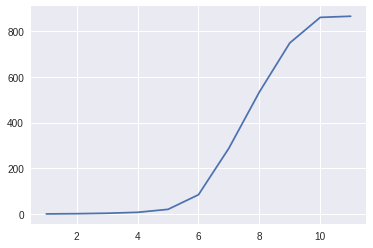

In [5]:
region_ct = []
for i in range(1, MAXLEVEL+1):
    tp = cut_by_level(df_fill, i)
    tp = tp[tp["Level_2"]=="Basic cell groups and regions"]
    tp = level.loc[tp.index]
    region_ct.append(len(tp))
    
plt.plot(np.arange(1, MAXLEVEL+1), region_ct)

In [6]:
brain_regions = cut_by_level(df_fill, 10)
brain_regions = brain_regions[brain_regions["Level_2"]=="Basic cell groups and regions"]
brain_levels = level.loc[brain_regions.index]

print(brain_levels.shape)
brain_levels.head()

(861, 3)


,Abbrevation,Description,level
1,,,
68,FRP1,"Frontal pole, layer 1",8
667,FRP2/3,"Frontal pole, layer 2/3",8
526157192,FRP5,"Frontal pole, layer 5",8
526157196,FRP6a,"Frontal pole, layer 6a",8
526322264,FRP6b,"Frontal pole, layer 6b",8


## Load neuron distribution

In [7]:
dendrite_location = pd.DataFrame(columns=brain_levels.index)
axon_location = pd.DataFrame(columns=brain_levels.index)
hemi_location = pd.DataFrame(columns=['hemisphere'])
ncol = brain_levels.shape[0]

data_dir = "./data/CCF/mapped/location/"
standard_columns = ['Unnamed: 0', '(basal) dendrite', 'axon', 'dataset', 'hemisphere_id', 'structure_id']

for input_table in os.listdir(data_dir):
    if input_table.endswith(".csv"):
        input_table = os.path.join(data_dir, input_table)
    else:
        continue
    df = pd.read_csv(input_table)
    
    # Check column names 
    check_columns = True
    if df.shape[1] != len(standard_columns):
        print(input_table)
        continue
    for i,col in enumerate(df.columns.tolist()):
        if col != standard_columns[i]:
            print(input_table)
            check_columns = False
            break
    if not check_columns:
        continue
        
    # Load table  
    df = pd.read_csv(input_table, index_col=[5])
    df = df.drop([df.columns[0]], axis=1)
    df = df.fillna(0)
    cell_id = '_'.join(df.dataset.iloc[0].split('_')[:2])
    hemi_id = df.hemisphere_id.iloc[0]
    df.dataset = cell_id

    # Remove unwanted rows
    lab = []
    for i in range(len(df)):
        if not df.index[i] in brain_levels.index.tolist():
            lab.append(df.index[i])
    df = df.drop(lab)

    # Dendrite
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["(basal) dendrite"].tolist()
    dendrite_location = pd.concat([dendrite_location, tp])
    # Axon
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["axon"].tolist()
    axon_location = pd.concat([axon_location, tp])
    # hemisphere
    tp = pd.DataFrame([hemi_id], columns=['hemisphere'], index=[cell_id])
    hemi_location = pd.concat([hemi_location, tp])

dendrite_location.columns = brain_levels.loc[dendrite_location.columns, 'Description']
axon_location.columns = brain_levels.loc[axon_location.columns, 'Description']

./data/CCF/mapped/location/17302_070_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_091_SYY_WW_ZSJ_08032018.ano.eswc.csv
./data/CCF/mapped/location/17302_069_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_022_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_058_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_073_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_061_LjL_09072018.ano.eswc.csv
./data/CCF/mapped/location/17302_051_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_067_LiuAn_LijLiu_05152018.ano.swc.csv
./data/CCF/mapped/location/17302_045_LjLiu_05132018.ano.eswc.csv
./data/CCF/mapped/location/17302_085_HGD_LijLiu_07282018.ano.eswc.csv
./data/CCF/mapped/location/17302_031_HGD_LijLiu_07062018.ano.eswc.csv
./data/CCF/mapped/location/17302_068_LiuAn_LijLiu_05152018.ano.swc.ano.swc.csv
./data/CCF/mapped/location/17302_072_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_071_YJ_Lj

In [8]:
pickle.dump([dendrite_location, axon_location, hemi_location, brain_levels, brain_regions],
           open("data/CCF/mapped/location/17302_location.pickle", 'wb'))



In [9]:
dendrite_location, axon_location, hemi_location, brain_levels, brain_regions = pickle.load(open("data/CCF/mapped/location/17302_location.pickle", 'rb'))

location_sum = pd.DataFrame(np.sum(dendrite_location, axis=0)).sort_values(0, ascending=False)
lab = location_sum[location_sum[0]>0].index

writer = pd.ExcelWriter('Table/17302_location.xlsx')
dendrite_location[lab].to_excel(writer,'Dendrite')
axon_location[lab].to_excel(writer,'Axon')
hemi_location.to_excel(writer,'Hemisphere')
brain_levels.to_excel(writer, 'Brain_regions')
writer.save()

## Examine brain region assignment

Regions used:	 26


,0
Description,
Caudoputamen,110576.984332
"Substantia nigra, reticular part",15852.497528
"Primary visual area, layer 2/3",14428.404096
"Gustatory areas, layer 6a",6892.678766
Claustrum,6502.433237
"Primary somatosensory area, barrel field, layer 4",5334.571484
"Globus pallidus, external segment",4342.303671
"Orbital area, ventrolateral part, layer 5",4322.571374
Ventral posteromedial nucleus of the thalamus,3836.838053


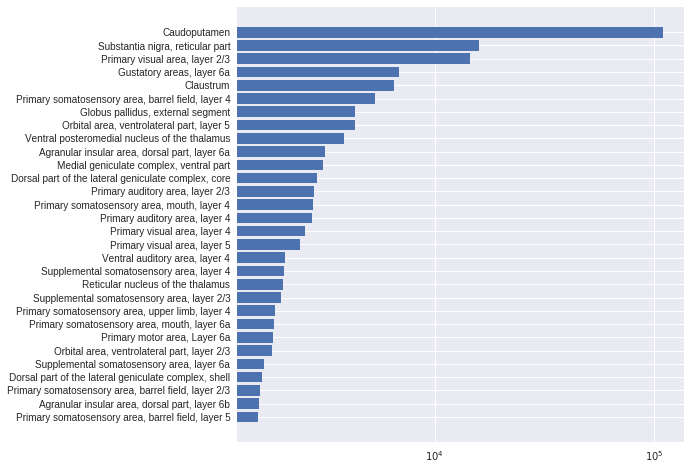

In [10]:
features = pd.read_excel("Table/Global_features.xlsx")
features['Type'] = pd.Categorical(features['Type'])   

location_all = axon_location + dendrite_location
# location = dendrite_location
use_cells = sorted(list(set(features.index).intersection(set(location_all.index))))

features = features.loc[use_cells]
location = location_all.loc[use_cells]
# location.columns = brain_levels.loc[location.columns, "Description"]


# Cell types
celltypes = pd.DataFrame(features['Type'])
u_celltypes = list(set(celltypes['Type']))

assert len(u_celltypes)<10
celltypes_pal = ['C'+str(i) for i in range(len(u_celltypes))]
celltypes_lut = dict(zip(sorted(u_celltypes), celltypes_pal))
celltypes_col = []
for tp in celltypes['Type'].tolist():
    celltypes_col.append(celltypes_lut[tp])


location_sum = pd.DataFrame(np.sum(location, axis=0)).sort_values(0, ascending=False)

plt.figure(figsize=(8,8))
n_disp = 30
plt.barh(np.linspace(n_disp,1,n_disp), location_sum.iloc[:n_disp, 0], tick_label=location_sum.index[:n_disp])
plt.xscale('log')

lab = [i for i in range(location.shape[1]) if location.iloc[:,i].sum()>np.percentile(location_sum[0], 97)]

print("Regions used:\t", len(lab))
location = location.iloc[:, lab]
location_sum.iloc[0:n_disp, :]

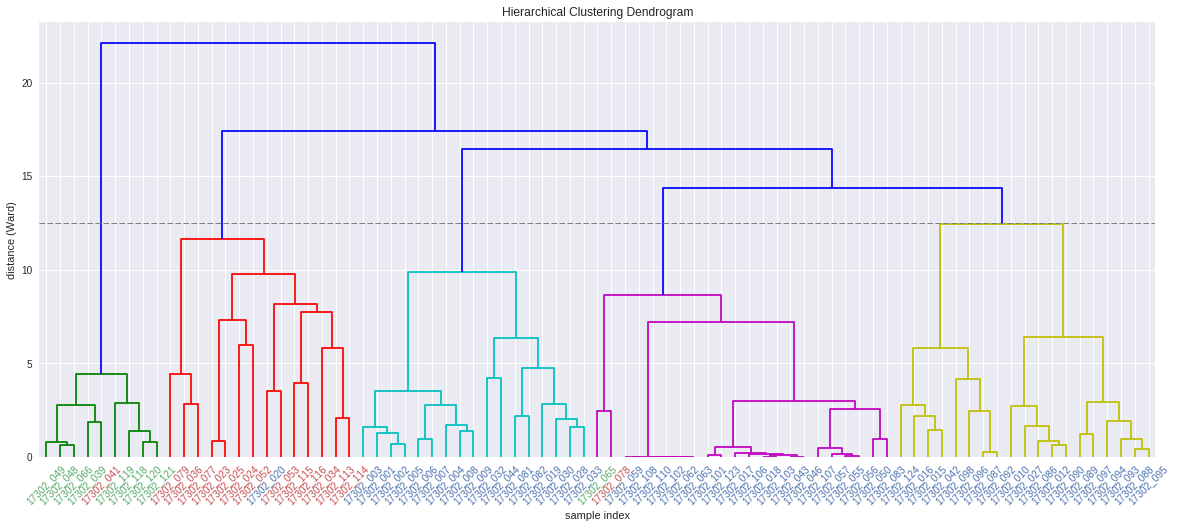

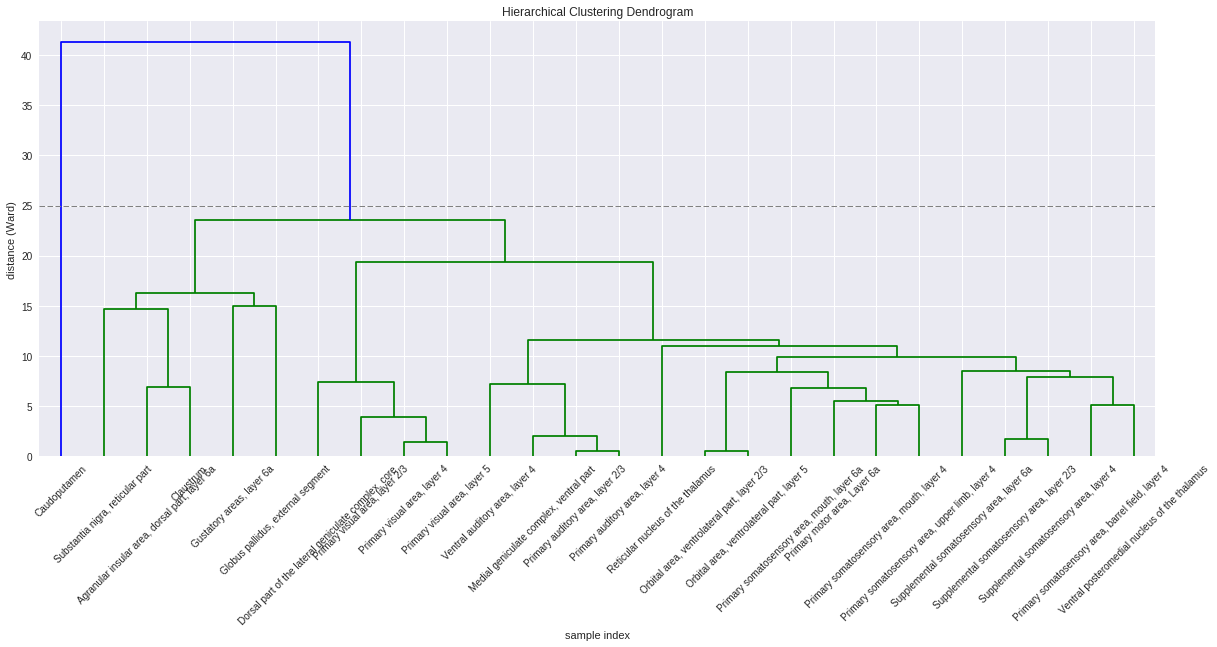

In [11]:
df = pd.DataFrame(scale(np.log10(location+1), axis=1), columns=location.columns, index=location.index)

# Plot 1: Hierarchical clustering (by samples)

Z_sample = linkage(df, 'ward')

thres_sample = 12.5
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_sample, labels=df.index, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres_sample, orientation="top",
              )
plt.axhline(y=thres_sample, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
my_color=celltypes.loc[d['ivl'], 'Type'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(celltypes_pal[my_color[num]])
    
# Plot 2: Hierarchical clustering (by features)

Z_feature = linkage(df.transpose(), method = 'ward', metric='euclidean')

thres_feature = 25
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z_feature, labels=df.columns, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres_feature, orientation="top",
              )
plt.axhline(y=thres_feature, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

In [12]:
clusters = pd.DataFrame({'cluster':fcluster(Z_sample, thres_sample, criterion="distance")}, index=df.index)
clusters.to_excel("Table/R_cluster.xlsx")

/local1/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


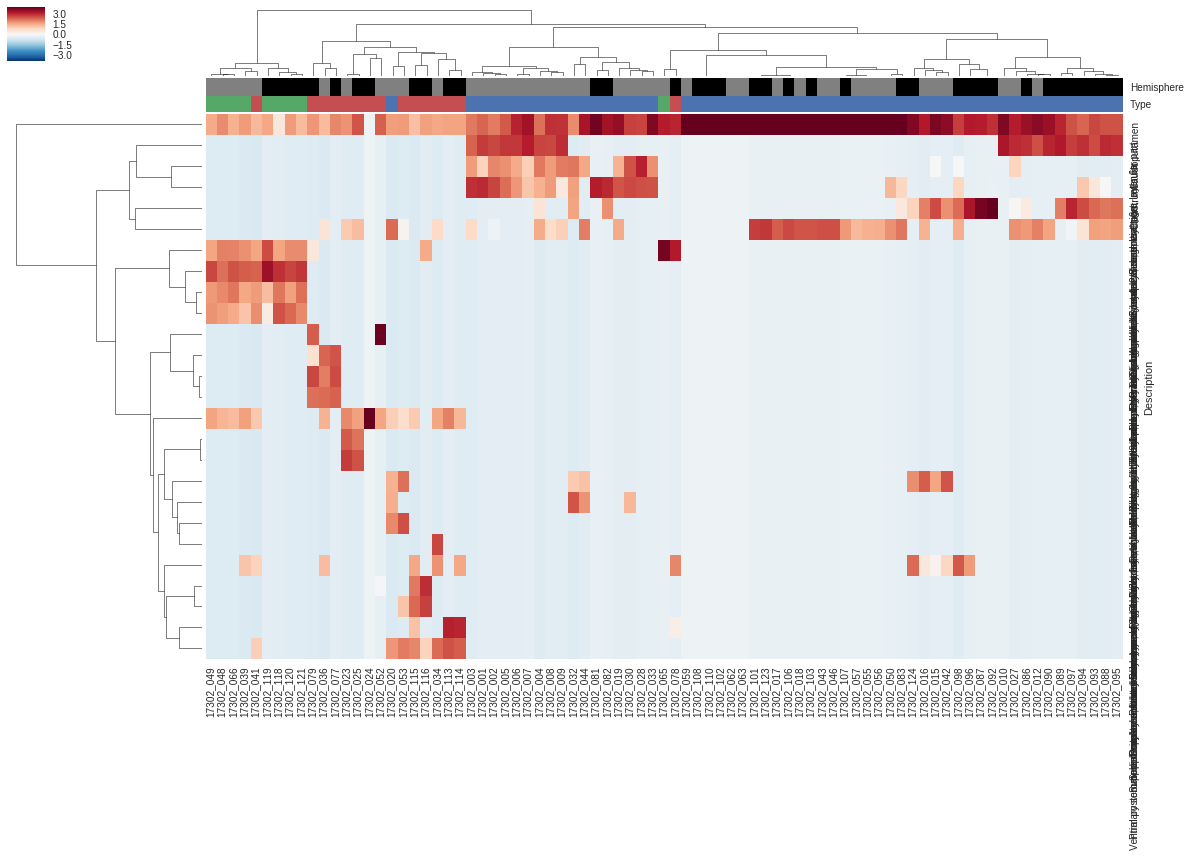

In [13]:
hemi_lut = {1:'grey', 2:'black'}
hemi_col = [hemi_lut[i] for i in hemi_location.loc[df.index, 'hemisphere'].tolist()]
col_colors = pd.DataFrame({'Type':celltypes_col, 'Hemisphere':hemi_col}, index=df.index)

g = sns.clustermap(df.transpose(), linewidths=0.0, linecolor='white',
                   row_linkage=Z_feature,
                   col_linkage=Z_sample,
                   col_colors=col_colors,
                   vmax=np.percentile(df, 99),
                   vmin=np.percentile(df, 1),
                   annot=False, figsize=(20,12))
g.savefig("Figure/Heatmap_Location_AllNeurons.pdf")

## Compare feature cluster and region cluster

In [ ]:
rcl = pd.read_excel("Table/R_cluster.xlsx")
fcl = pd.read_excel("Table/F_cluster.xlsx")+1

s1 = set(rcl.index.tolist())
s2 = set(fcl.index.tolist())
lab = list(s1.intersection(s2))
print("Number of cells:\t", len(lab))

rcl = rcl.loc[lab]
fcl = fcl.loc[lab]